# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

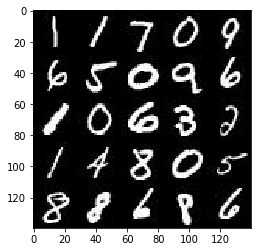

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

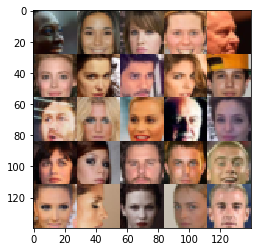

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inp = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels], "real_input")
    z_inp = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    lr = tf.placeholder(tf.float32, None, "learning_rate")
    
    return real_inp, z_inp, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.01 # as suggested in the video
    with tf.variable_scope('discriminator', reuse=reuse):
        
        hidden_layer1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * hidden_layer1, hidden_layer1)# making the relu leak!
      
        hidden_layer2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(hidden_layer2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        hidden_layer3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(hidden_layer3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        flat = tf.reshape(relu3,(-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.01 # as suggested in the video
    with tf.variable_scope('generator', reuse= (not is_train)):
        
        hidden_layer1 = tf.layers.dense(z, 7*7*512)
        hidden_layer1 = tf.reshape(hidden_layer1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(hidden_layer1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)# making the relu leak!
      
        hidden_layer2 = tf.layers.conv2d_transpose(relu1, 256, 3, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(hidden_layer2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        hidden_layer3 = tf.layers.conv2d_transpose(relu2, 128, 3, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(hidden_layer3, training=is_train)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.01
    gen_mod = generator(input_z, out_channel_dim)
    disc_mod_real, disc_logits_real = discriminator(input_real)
    disc_mod_fake, disc_logits_fake = discriminator(gen_mod, reuse=True)

    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real\
                                                                         , labels=tf.ones_like(disc_logits_real) * alpha))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake\
                                                                         , labels=tf.zeros_like(disc_logits_fake)))
    disc_loss = disc_loss_real + disc_loss_fake

    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,labels=tf.ones_like(disc_logits_fake)))
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    disc_vars = [v for v in variables if v.name.startswith('discriminator')]
    gen_vars = [v for v in variables if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
        
    return disc_train_opt, gen_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inp, z_inp, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    disc_loss, gen_loss = model_loss(real_inp, z_inp, data_shape[3])
    
    disc_train_opt, gen_train_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_train_opt, feed_dict={real_inp: batch_images, z_inp: batch_z,lr:learning_rate})
                _ = sess.run(gen_train_opt, feed_dict={z_inp: batch_z, real_inp: batch_images,lr:learning_rate})
                

                if steps % 10 == 0:
                    train_loss_disc = sess.run(disc_loss, {z_inp: batch_z, real_inp: batch_images})
                    train_loss_gen = gen_loss.eval({z_inp: batch_z})

                    print("Epoch {}/{} , ".format(epoch_i+1, epoch_count),
                          "Batch {} , ".format(steps),
                          "Generator Loss: {:.4f} , ".format(train_loss_gen),
                          "Discriminator Loss: {:.4f}".format(train_loss_disc))
                if steps % 100 == 0:
                    show_generator_output(sess, 16, z_inp, data_shape[3], data_image_mode)                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ,  Batch 10 ,  Generator Loss: 5.6242 ,  Discriminator Loss: 0.0707
Epoch 1/2 ,  Batch 20 ,  Generator Loss: 6.1238 ,  Discriminator Loss: 0.0604
Epoch 1/2 ,  Batch 30 ,  Generator Loss: 5.8456 ,  Discriminator Loss: 0.0614
Epoch 1/2 ,  Batch 40 ,  Generator Loss: 6.2488 ,  Discriminator Loss: 0.0671
Epoch 1/2 ,  Batch 50 ,  Generator Loss: 5.5079 ,  Discriminator Loss: 0.0679
Epoch 1/2 ,  Batch 60 ,  Generator Loss: 4.6060 ,  Discriminator Loss: 0.0695
Epoch 1/2 ,  Batch 70 ,  Generator Loss: 4.4516 ,  Discriminator Loss: 0.0701
Epoch 1/2 ,  Batch 80 ,  Generator Loss: 5.6503 ,  Discriminator Loss: 0.0682
Epoch 1/2 ,  Batch 90 ,  Generator Loss: 5.5821 ,  Discriminator Loss: 0.0662
Epoch 1/2 ,  Batch 100 ,  Generator Loss: 5.1601 ,  Discriminator Loss: 0.0647


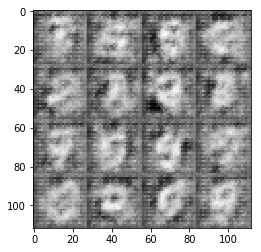

Epoch 1/2 ,  Batch 110 ,  Generator Loss: 5.8131 ,  Discriminator Loss: 0.0666
Epoch 1/2 ,  Batch 120 ,  Generator Loss: 5.6425 ,  Discriminator Loss: 0.0648
Epoch 1/2 ,  Batch 130 ,  Generator Loss: 5.4739 ,  Discriminator Loss: 0.0628
Epoch 1/2 ,  Batch 140 ,  Generator Loss: 5.7227 ,  Discriminator Loss: 0.0660
Epoch 1/2 ,  Batch 150 ,  Generator Loss: 5.5648 ,  Discriminator Loss: 0.0641
Epoch 1/2 ,  Batch 160 ,  Generator Loss: 5.6036 ,  Discriminator Loss: 0.0629
Epoch 1/2 ,  Batch 170 ,  Generator Loss: 4.6390 ,  Discriminator Loss: 0.0667
Epoch 1/2 ,  Batch 180 ,  Generator Loss: 4.6765 ,  Discriminator Loss: 0.0663
Epoch 1/2 ,  Batch 190 ,  Generator Loss: 5.0958 ,  Discriminator Loss: 0.0631
Epoch 1/2 ,  Batch 200 ,  Generator Loss: 5.1163 ,  Discriminator Loss: 0.0630


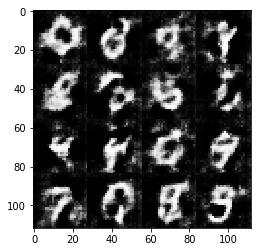

Epoch 1/2 ,  Batch 210 ,  Generator Loss: 4.7181 ,  Discriminator Loss: 0.0658
Epoch 1/2 ,  Batch 220 ,  Generator Loss: 4.6914 ,  Discriminator Loss: 0.0662
Epoch 1/2 ,  Batch 230 ,  Generator Loss: 4.6521 ,  Discriminator Loss: 0.0665
Epoch 1/2 ,  Batch 240 ,  Generator Loss: 4.7342 ,  Discriminator Loss: 0.0657
Epoch 1/2 ,  Batch 250 ,  Generator Loss: 4.7538 ,  Discriminator Loss: 0.0656
Epoch 1/2 ,  Batch 260 ,  Generator Loss: 4.7956 ,  Discriminator Loss: 0.0651
Epoch 1/2 ,  Batch 270 ,  Generator Loss: 4.8323 ,  Discriminator Loss: 0.0649
Epoch 1/2 ,  Batch 280 ,  Generator Loss: 4.9077 ,  Discriminator Loss: 0.0644
Epoch 1/2 ,  Batch 290 ,  Generator Loss: 4.9993 ,  Discriminator Loss: 0.0637
Epoch 1/2 ,  Batch 300 ,  Generator Loss: 4.9382 ,  Discriminator Loss: 0.0639


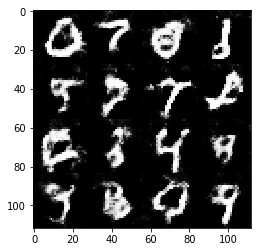

Epoch 1/2 ,  Batch 310 ,  Generator Loss: 4.7175 ,  Discriminator Loss: 0.0659
Epoch 1/2 ,  Batch 320 ,  Generator Loss: 5.3162 ,  Discriminator Loss: 0.0617
Epoch 1/2 ,  Batch 330 ,  Generator Loss: 4.7430 ,  Discriminator Loss: 0.0656
Epoch 1/2 ,  Batch 340 ,  Generator Loss: 4.8271 ,  Discriminator Loss: 0.0646
Epoch 1/2 ,  Batch 350 ,  Generator Loss: 4.7846 ,  Discriminator Loss: 0.0652
Epoch 1/2 ,  Batch 360 ,  Generator Loss: 5.0293 ,  Discriminator Loss: 0.0633
Epoch 1/2 ,  Batch 370 ,  Generator Loss: 4.9601 ,  Discriminator Loss: 0.0643
Epoch 1/2 ,  Batch 380 ,  Generator Loss: 4.9170 ,  Discriminator Loss: 0.0640
Epoch 1/2 ,  Batch 390 ,  Generator Loss: 4.8587 ,  Discriminator Loss: 0.0645
Epoch 1/2 ,  Batch 400 ,  Generator Loss: 4.8846 ,  Discriminator Loss: 0.0644


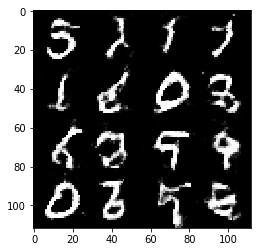

Epoch 1/2 ,  Batch 410 ,  Generator Loss: 4.8875 ,  Discriminator Loss: 0.0642
Epoch 1/2 ,  Batch 420 ,  Generator Loss: 4.8118 ,  Discriminator Loss: 0.0650
Epoch 1/2 ,  Batch 430 ,  Generator Loss: 5.0070 ,  Discriminator Loss: 0.0634
Epoch 1/2 ,  Batch 440 ,  Generator Loss: 4.9320 ,  Discriminator Loss: 0.0641
Epoch 1/2 ,  Batch 450 ,  Generator Loss: 4.9420 ,  Discriminator Loss: 0.0639
Epoch 1/2 ,  Batch 460 ,  Generator Loss: 4.7677 ,  Discriminator Loss: 0.0652
Epoch 2/2 ,  Batch 470 ,  Generator Loss: 4.7784 ,  Discriminator Loss: 0.0650
Epoch 2/2 ,  Batch 480 ,  Generator Loss: 5.0850 ,  Discriminator Loss: 0.0630
Epoch 2/2 ,  Batch 490 ,  Generator Loss: 4.7956 ,  Discriminator Loss: 0.0649
Epoch 2/2 ,  Batch 500 ,  Generator Loss: 4.6864 ,  Discriminator Loss: 0.0659


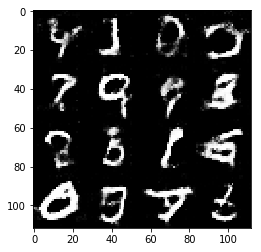

Epoch 2/2 ,  Batch 510 ,  Generator Loss: 4.8210 ,  Discriminator Loss: 0.0647
Epoch 2/2 ,  Batch 520 ,  Generator Loss: 4.9879 ,  Discriminator Loss: 0.0636
Epoch 2/2 ,  Batch 530 ,  Generator Loss: 4.9631 ,  Discriminator Loss: 0.0636
Epoch 2/2 ,  Batch 540 ,  Generator Loss: 4.9983 ,  Discriminator Loss: 0.0635
Epoch 2/2 ,  Batch 550 ,  Generator Loss: 4.8248 ,  Discriminator Loss: 0.0647
Epoch 2/2 ,  Batch 560 ,  Generator Loss: 4.8257 ,  Discriminator Loss: 0.0648
Epoch 2/2 ,  Batch 570 ,  Generator Loss: 4.8345 ,  Discriminator Loss: 0.0648
Epoch 2/2 ,  Batch 580 ,  Generator Loss: 4.7607 ,  Discriminator Loss: 0.0653
Epoch 2/2 ,  Batch 590 ,  Generator Loss: 4.9976 ,  Discriminator Loss: 0.0634
Epoch 2/2 ,  Batch 600 ,  Generator Loss: 4.8299 ,  Discriminator Loss: 0.0646


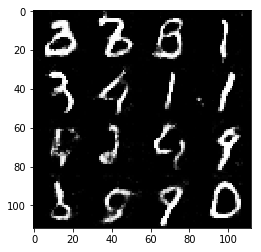

Epoch 2/2 ,  Batch 610 ,  Generator Loss: 4.8085 ,  Discriminator Loss: 0.0647
Epoch 2/2 ,  Batch 620 ,  Generator Loss: 4.7923 ,  Discriminator Loss: 0.0650
Epoch 2/2 ,  Batch 630 ,  Generator Loss: 4.9469 ,  Discriminator Loss: 0.0637
Epoch 2/2 ,  Batch 640 ,  Generator Loss: 4.8226 ,  Discriminator Loss: 0.0646
Epoch 2/2 ,  Batch 650 ,  Generator Loss: 4.9457 ,  Discriminator Loss: 0.0638
Epoch 2/2 ,  Batch 660 ,  Generator Loss: 4.8472 ,  Discriminator Loss: 0.0645
Epoch 2/2 ,  Batch 670 ,  Generator Loss: 5.0573 ,  Discriminator Loss: 0.0633
Epoch 2/2 ,  Batch 680 ,  Generator Loss: 4.8488 ,  Discriminator Loss: 0.0645
Epoch 2/2 ,  Batch 690 ,  Generator Loss: 4.8160 ,  Discriminator Loss: 0.0646
Epoch 2/2 ,  Batch 700 ,  Generator Loss: 5.0303 ,  Discriminator Loss: 0.0632


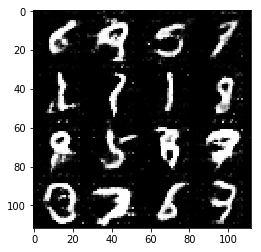

Epoch 2/2 ,  Batch 710 ,  Generator Loss: 4.7646 ,  Discriminator Loss: 0.0653
Epoch 2/2 ,  Batch 720 ,  Generator Loss: 4.9233 ,  Discriminator Loss: 0.0639
Epoch 2/2 ,  Batch 730 ,  Generator Loss: 4.9352 ,  Discriminator Loss: 0.0637
Epoch 2/2 ,  Batch 740 ,  Generator Loss: 4.9263 ,  Discriminator Loss: 0.0643
Epoch 2/2 ,  Batch 750 ,  Generator Loss: 4.9056 ,  Discriminator Loss: 0.0640
Epoch 2/2 ,  Batch 760 ,  Generator Loss: 4.7767 ,  Discriminator Loss: 0.0651
Epoch 2/2 ,  Batch 770 ,  Generator Loss: 4.8303 ,  Discriminator Loss: 0.0648
Epoch 2/2 ,  Batch 780 ,  Generator Loss: 4.8672 ,  Discriminator Loss: 0.0644
Epoch 2/2 ,  Batch 790 ,  Generator Loss: 4.7918 ,  Discriminator Loss: 0.0648
Epoch 2/2 ,  Batch 800 ,  Generator Loss: 4.8734 ,  Discriminator Loss: 0.0645


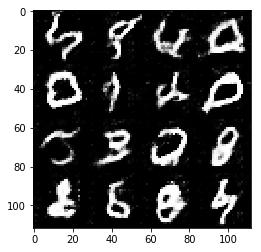

Epoch 2/2 ,  Batch 810 ,  Generator Loss: 4.9078 ,  Discriminator Loss: 0.0641
Epoch 2/2 ,  Batch 820 ,  Generator Loss: 4.7642 ,  Discriminator Loss: 0.0651
Epoch 2/2 ,  Batch 830 ,  Generator Loss: 5.0837 ,  Discriminator Loss: 0.0631
Epoch 2/2 ,  Batch 840 ,  Generator Loss: 4.9579 ,  Discriminator Loss: 0.0635
Epoch 2/2 ,  Batch 850 ,  Generator Loss: 4.8268 ,  Discriminator Loss: 0.0647
Epoch 2/2 ,  Batch 860 ,  Generator Loss: 5.0207 ,  Discriminator Loss: 0.0635
Epoch 2/2 ,  Batch 870 ,  Generator Loss: 4.9752 ,  Discriminator Loss: 0.0636
Epoch 2/2 ,  Batch 880 ,  Generator Loss: 4.8824 ,  Discriminator Loss: 0.0642
Epoch 2/2 ,  Batch 890 ,  Generator Loss: 4.8034 ,  Discriminator Loss: 0.0647
Epoch 2/2 ,  Batch 900 ,  Generator Loss: 4.8377 ,  Discriminator Loss: 0.0646


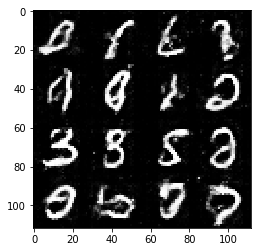

Epoch 2/2 ,  Batch 910 ,  Generator Loss: 5.0424 ,  Discriminator Loss: 0.0635
Epoch 2/2 ,  Batch 920 ,  Generator Loss: 4.9184 ,  Discriminator Loss: 0.0639
Epoch 2/2 ,  Batch 930 ,  Generator Loss: 4.9351 ,  Discriminator Loss: 0.0640


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches
          ,mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ,  Batch 10 ,  Generator Loss: 1.8352 ,  Discriminator Loss: 0.2808
Epoch 1/1 ,  Batch 20 ,  Generator Loss: 2.9266 ,  Discriminator Loss: 0.1433
Epoch 1/1 ,  Batch 30 ,  Generator Loss: 3.6106 ,  Discriminator Loss: 0.1073
Epoch 1/1 ,  Batch 40 ,  Generator Loss: 3.4842 ,  Discriminator Loss: 0.1130
Epoch 1/1 ,  Batch 50 ,  Generator Loss: 4.6205 ,  Discriminator Loss: 0.0862
Epoch 1/1 ,  Batch 60 ,  Generator Loss: 4.5874 ,  Discriminator Loss: 0.0838
Epoch 1/1 ,  Batch 70 ,  Generator Loss: 4.3952 ,  Discriminator Loss: 0.0853
Epoch 1/1 ,  Batch 80 ,  Generator Loss: 5.4190 ,  Discriminator Loss: 0.0745
Epoch 1/1 ,  Batch 90 ,  Generator Loss: 4.9402 ,  Discriminator Loss: 0.0751
Epoch 1/1 ,  Batch 100 ,  Generator Loss: 4.6542 ,  Discriminator Loss: 0.0790


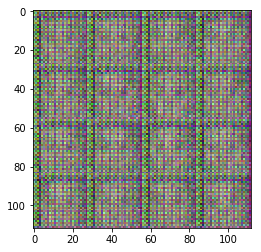

Epoch 1/1 ,  Batch 110 ,  Generator Loss: 4.9468 ,  Discriminator Loss: 0.0730
Epoch 1/1 ,  Batch 120 ,  Generator Loss: 5.1352 ,  Discriminator Loss: 0.0696
Epoch 1/1 ,  Batch 130 ,  Generator Loss: 4.4818 ,  Discriminator Loss: 0.0752
Epoch 1/1 ,  Batch 140 ,  Generator Loss: 5.9292 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 150 ,  Generator Loss: 5.1011 ,  Discriminator Loss: 0.0687
Epoch 1/1 ,  Batch 160 ,  Generator Loss: 6.0709 ,  Discriminator Loss: 0.0645
Epoch 1/1 ,  Batch 170 ,  Generator Loss: 5.2336 ,  Discriminator Loss: 0.0671
Epoch 1/1 ,  Batch 180 ,  Generator Loss: 5.0031 ,  Discriminator Loss: 0.0683
Epoch 1/1 ,  Batch 190 ,  Generator Loss: 5.4431 ,  Discriminator Loss: 0.0663
Epoch 1/1 ,  Batch 200 ,  Generator Loss: 4.8658 ,  Discriminator Loss: 0.0698


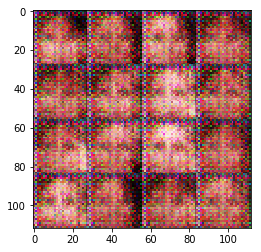

Epoch 1/1 ,  Batch 210 ,  Generator Loss: 4.6547 ,  Discriminator Loss: 0.0742
Epoch 1/1 ,  Batch 220 ,  Generator Loss: 4.8550 ,  Discriminator Loss: 0.0715
Epoch 1/1 ,  Batch 230 ,  Generator Loss: 5.1085 ,  Discriminator Loss: 0.0704
Epoch 1/1 ,  Batch 240 ,  Generator Loss: 5.0866 ,  Discriminator Loss: 0.0693
Epoch 1/1 ,  Batch 250 ,  Generator Loss: 5.0374 ,  Discriminator Loss: 0.0688
Epoch 1/1 ,  Batch 260 ,  Generator Loss: 5.0891 ,  Discriminator Loss: 0.0691
Epoch 1/1 ,  Batch 270 ,  Generator Loss: 5.4322 ,  Discriminator Loss: 0.0660
Epoch 1/1 ,  Batch 280 ,  Generator Loss: 5.1768 ,  Discriminator Loss: 0.0686
Epoch 1/1 ,  Batch 290 ,  Generator Loss: 4.8969 ,  Discriminator Loss: 0.0682
Epoch 1/1 ,  Batch 300 ,  Generator Loss: 4.9246 ,  Discriminator Loss: 0.0690


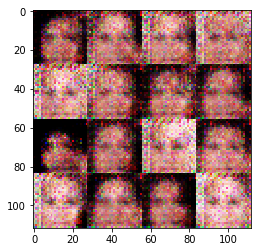

Epoch 1/1 ,  Batch 310 ,  Generator Loss: 5.0767 ,  Discriminator Loss: 0.0682
Epoch 1/1 ,  Batch 320 ,  Generator Loss: 5.1136 ,  Discriminator Loss: 0.0672
Epoch 1/1 ,  Batch 330 ,  Generator Loss: 4.9198 ,  Discriminator Loss: 0.0683
Epoch 1/1 ,  Batch 340 ,  Generator Loss: 5.1824 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 350 ,  Generator Loss: 5.1607 ,  Discriminator Loss: 0.0670
Epoch 1/1 ,  Batch 360 ,  Generator Loss: 5.1173 ,  Discriminator Loss: 0.0672
Epoch 1/1 ,  Batch 370 ,  Generator Loss: 5.0716 ,  Discriminator Loss: 0.0680
Epoch 1/1 ,  Batch 380 ,  Generator Loss: 5.0432 ,  Discriminator Loss: 0.0688
Epoch 1/1 ,  Batch 390 ,  Generator Loss: 5.0734 ,  Discriminator Loss: 0.0689
Epoch 1/1 ,  Batch 400 ,  Generator Loss: 4.9727 ,  Discriminator Loss: 0.0691


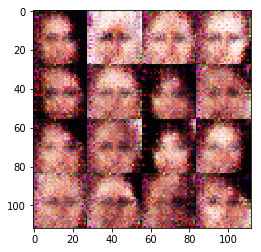

Epoch 1/1 ,  Batch 410 ,  Generator Loss: 4.9724 ,  Discriminator Loss: 0.0680
Epoch 1/1 ,  Batch 420 ,  Generator Loss: 5.0556 ,  Discriminator Loss: 0.0684
Epoch 1/1 ,  Batch 430 ,  Generator Loss: 4.9790 ,  Discriminator Loss: 0.0697
Epoch 1/1 ,  Batch 440 ,  Generator Loss: 4.9654 ,  Discriminator Loss: 0.0691
Epoch 1/1 ,  Batch 450 ,  Generator Loss: 4.8506 ,  Discriminator Loss: 0.0693
Epoch 1/1 ,  Batch 460 ,  Generator Loss: 4.9235 ,  Discriminator Loss: 0.0694
Epoch 1/1 ,  Batch 470 ,  Generator Loss: 4.8612 ,  Discriminator Loss: 0.0696
Epoch 1/1 ,  Batch 480 ,  Generator Loss: 4.8424 ,  Discriminator Loss: 0.0702
Epoch 1/1 ,  Batch 490 ,  Generator Loss: 5.0396 ,  Discriminator Loss: 0.0676
Epoch 1/1 ,  Batch 500 ,  Generator Loss: 4.8108 ,  Discriminator Loss: 0.0698


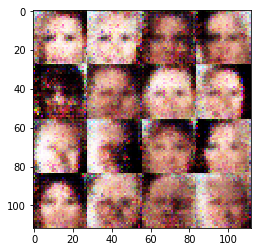

Epoch 1/1 ,  Batch 510 ,  Generator Loss: 4.9629 ,  Discriminator Loss: 0.0680
Epoch 1/1 ,  Batch 520 ,  Generator Loss: 4.8618 ,  Discriminator Loss: 0.0702
Epoch 1/1 ,  Batch 530 ,  Generator Loss: 4.8507 ,  Discriminator Loss: 0.0695
Epoch 1/1 ,  Batch 540 ,  Generator Loss: 4.9364 ,  Discriminator Loss: 0.0683
Epoch 1/1 ,  Batch 550 ,  Generator Loss: 4.9371 ,  Discriminator Loss: 0.0687
Epoch 1/1 ,  Batch 560 ,  Generator Loss: 4.9913 ,  Discriminator Loss: 0.0680
Epoch 1/1 ,  Batch 570 ,  Generator Loss: 4.8198 ,  Discriminator Loss: 0.0693
Epoch 1/1 ,  Batch 580 ,  Generator Loss: 4.9697 ,  Discriminator Loss: 0.0675
Epoch 1/1 ,  Batch 590 ,  Generator Loss: 4.9074 ,  Discriminator Loss: 0.0677
Epoch 1/1 ,  Batch 600 ,  Generator Loss: 5.0198 ,  Discriminator Loss: 0.0669


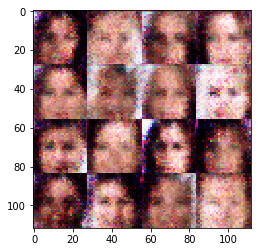

Epoch 1/1 ,  Batch 610 ,  Generator Loss: 4.9383 ,  Discriminator Loss: 0.0679
Epoch 1/1 ,  Batch 620 ,  Generator Loss: 4.8738 ,  Discriminator Loss: 0.0679
Epoch 1/1 ,  Batch 630 ,  Generator Loss: 4.9072 ,  Discriminator Loss: 0.0677
Epoch 1/1 ,  Batch 640 ,  Generator Loss: 4.9764 ,  Discriminator Loss: 0.0676
Epoch 1/1 ,  Batch 650 ,  Generator Loss: 4.8806 ,  Discriminator Loss: 0.0677
Epoch 1/1 ,  Batch 660 ,  Generator Loss: 4.9778 ,  Discriminator Loss: 0.0668
Epoch 1/1 ,  Batch 670 ,  Generator Loss: 4.9759 ,  Discriminator Loss: 0.0668
Epoch 1/1 ,  Batch 680 ,  Generator Loss: 4.9001 ,  Discriminator Loss: 0.0681
Epoch 1/1 ,  Batch 690 ,  Generator Loss: 4.9697 ,  Discriminator Loss: 0.0672
Epoch 1/1 ,  Batch 700 ,  Generator Loss: 4.9660 ,  Discriminator Loss: 0.0667


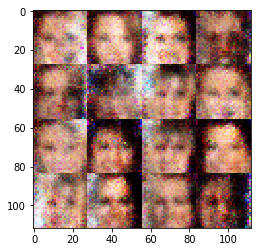

Epoch 1/1 ,  Batch 710 ,  Generator Loss: 5.0570 ,  Discriminator Loss: 0.0660
Epoch 1/1 ,  Batch 720 ,  Generator Loss: 4.9651 ,  Discriminator Loss: 0.0672
Epoch 1/1 ,  Batch 730 ,  Generator Loss: 4.9452 ,  Discriminator Loss: 0.0670
Epoch 1/1 ,  Batch 740 ,  Generator Loss: 4.9055 ,  Discriminator Loss: 0.0669
Epoch 1/1 ,  Batch 750 ,  Generator Loss: 4.9479 ,  Discriminator Loss: 0.0673
Epoch 1/1 ,  Batch 760 ,  Generator Loss: 5.0166 ,  Discriminator Loss: 0.0666
Epoch 1/1 ,  Batch 770 ,  Generator Loss: 4.9746 ,  Discriminator Loss: 0.0670
Epoch 1/1 ,  Batch 780 ,  Generator Loss: 5.0556 ,  Discriminator Loss: 0.0666
Epoch 1/1 ,  Batch 790 ,  Generator Loss: 4.9189 ,  Discriminator Loss: 0.0667
Epoch 1/1 ,  Batch 800 ,  Generator Loss: 4.9835 ,  Discriminator Loss: 0.0662


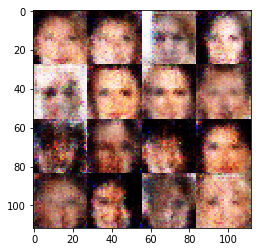

Epoch 1/1 ,  Batch 810 ,  Generator Loss: 5.0155 ,  Discriminator Loss: 0.0663
Epoch 1/1 ,  Batch 820 ,  Generator Loss: 5.0196 ,  Discriminator Loss: 0.0663
Epoch 1/1 ,  Batch 830 ,  Generator Loss: 4.9934 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 840 ,  Generator Loss: 5.0044 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 850 ,  Generator Loss: 4.9578 ,  Discriminator Loss: 0.0670
Epoch 1/1 ,  Batch 860 ,  Generator Loss: 5.0595 ,  Discriminator Loss: 0.0659
Epoch 1/1 ,  Batch 870 ,  Generator Loss: 5.0078 ,  Discriminator Loss: 0.0662
Epoch 1/1 ,  Batch 880 ,  Generator Loss: 5.0252 ,  Discriminator Loss: 0.0658
Epoch 1/1 ,  Batch 890 ,  Generator Loss: 5.0063 ,  Discriminator Loss: 0.0666
Epoch 1/1 ,  Batch 900 ,  Generator Loss: 5.0698 ,  Discriminator Loss: 0.0657


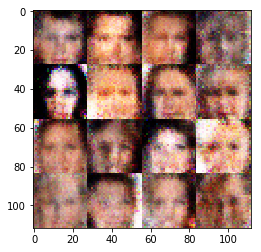

Epoch 1/1 ,  Batch 910 ,  Generator Loss: 5.0185 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 920 ,  Generator Loss: 5.0158 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 930 ,  Generator Loss: 5.0063 ,  Discriminator Loss: 0.0665
Epoch 1/1 ,  Batch 940 ,  Generator Loss: 5.0323 ,  Discriminator Loss: 0.0658
Epoch 1/1 ,  Batch 950 ,  Generator Loss: 5.0264 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 960 ,  Generator Loss: 4.9925 ,  Discriminator Loss: 0.0663
Epoch 1/1 ,  Batch 970 ,  Generator Loss: 5.0353 ,  Discriminator Loss: 0.0661
Epoch 1/1 ,  Batch 980 ,  Generator Loss: 5.0851 ,  Discriminator Loss: 0.0655
Epoch 1/1 ,  Batch 990 ,  Generator Loss: 4.9952 ,  Discriminator Loss: 0.0659
Epoch 1/1 ,  Batch 1000 ,  Generator Loss: 5.0247 ,  Discriminator Loss: 0.0656


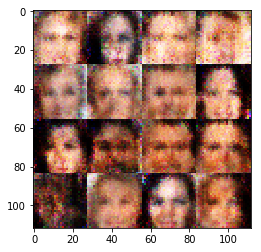

Epoch 1/1 ,  Batch 1010 ,  Generator Loss: 5.0569 ,  Discriminator Loss: 0.0659
Epoch 1/1 ,  Batch 1020 ,  Generator Loss: 5.0667 ,  Discriminator Loss: 0.0654
Epoch 1/1 ,  Batch 1030 ,  Generator Loss: 5.0597 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 1040 ,  Generator Loss: 5.0589 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 1050 ,  Generator Loss: 5.0005 ,  Discriminator Loss: 0.0658
Epoch 1/1 ,  Batch 1060 ,  Generator Loss: 5.0879 ,  Discriminator Loss: 0.0658
Epoch 1/1 ,  Batch 1070 ,  Generator Loss: 5.0235 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 1080 ,  Generator Loss: 5.1004 ,  Discriminator Loss: 0.0652
Epoch 1/1 ,  Batch 1090 ,  Generator Loss: 5.0891 ,  Discriminator Loss: 0.0653
Epoch 1/1 ,  Batch 1100 ,  Generator Loss: 5.0523 ,  Discriminator Loss: 0.0655


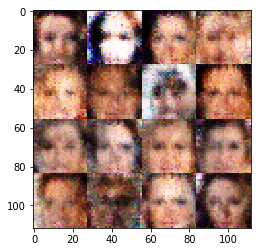

Epoch 1/1 ,  Batch 1110 ,  Generator Loss: 5.0281 ,  Discriminator Loss: 0.0657
Epoch 1/1 ,  Batch 1120 ,  Generator Loss: 5.1110 ,  Discriminator Loss: 0.0655
Epoch 1/1 ,  Batch 1130 ,  Generator Loss: 5.0454 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1140 ,  Generator Loss: 5.0392 ,  Discriminator Loss: 0.0653
Epoch 1/1 ,  Batch 1150 ,  Generator Loss: 5.0321 ,  Discriminator Loss: 0.0658
Epoch 1/1 ,  Batch 1160 ,  Generator Loss: 5.0340 ,  Discriminator Loss: 0.0656
Epoch 1/1 ,  Batch 1170 ,  Generator Loss: 5.0796 ,  Discriminator Loss: 0.0654
Epoch 1/1 ,  Batch 1180 ,  Generator Loss: 5.0612 ,  Discriminator Loss: 0.0655
Epoch 1/1 ,  Batch 1190 ,  Generator Loss: 5.1242 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1200 ,  Generator Loss: 5.0561 ,  Discriminator Loss: 0.0656


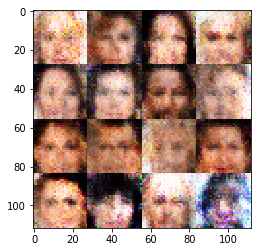

Epoch 1/1 ,  Batch 1210 ,  Generator Loss: 5.1280 ,  Discriminator Loss: 0.0655
Epoch 1/1 ,  Batch 1220 ,  Generator Loss: 5.0604 ,  Discriminator Loss: 0.0654
Epoch 1/1 ,  Batch 1230 ,  Generator Loss: 5.1144 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1240 ,  Generator Loss: 5.0419 ,  Discriminator Loss: 0.0654
Epoch 1/1 ,  Batch 1250 ,  Generator Loss: 5.0709 ,  Discriminator Loss: 0.0654
Epoch 1/1 ,  Batch 1260 ,  Generator Loss: 5.0475 ,  Discriminator Loss: 0.0652
Epoch 1/1 ,  Batch 1270 ,  Generator Loss: 5.0934 ,  Discriminator Loss: 0.0652
Epoch 1/1 ,  Batch 1280 ,  Generator Loss: 5.0543 ,  Discriminator Loss: 0.0653
Epoch 1/1 ,  Batch 1290 ,  Generator Loss: 5.0886 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1300 ,  Generator Loss: 5.0919 ,  Discriminator Loss: 0.0651


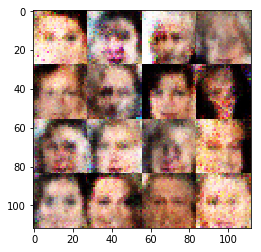

Epoch 1/1 ,  Batch 1310 ,  Generator Loss: 5.0668 ,  Discriminator Loss: 0.0645
Epoch 1/1 ,  Batch 1320 ,  Generator Loss: 5.1034 ,  Discriminator Loss: 0.0652
Epoch 1/1 ,  Batch 1330 ,  Generator Loss: 5.1416 ,  Discriminator Loss: 0.0645
Epoch 1/1 ,  Batch 1340 ,  Generator Loss: 5.0738 ,  Discriminator Loss: 0.0653
Epoch 1/1 ,  Batch 1350 ,  Generator Loss: 5.0684 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1360 ,  Generator Loss: 5.0535 ,  Discriminator Loss: 0.0652
Epoch 1/1 ,  Batch 1370 ,  Generator Loss: 5.0601 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1380 ,  Generator Loss: 5.0710 ,  Discriminator Loss: 0.0647
Epoch 1/1 ,  Batch 1390 ,  Generator Loss: 5.0998 ,  Discriminator Loss: 0.0648
Epoch 1/1 ,  Batch 1400 ,  Generator Loss: 5.0956 ,  Discriminator Loss: 0.0651


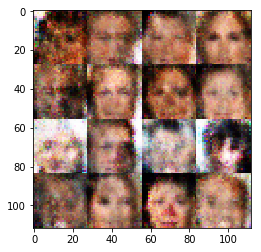

Epoch 1/1 ,  Batch 1410 ,  Generator Loss: 5.0765 ,  Discriminator Loss: 0.0647
Epoch 1/1 ,  Batch 1420 ,  Generator Loss: 5.1426 ,  Discriminator Loss: 0.0646
Epoch 1/1 ,  Batch 1430 ,  Generator Loss: 5.0296 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1440 ,  Generator Loss: 5.1339 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1450 ,  Generator Loss: 5.0932 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1460 ,  Generator Loss: 5.1208 ,  Discriminator Loss: 0.0647
Epoch 1/1 ,  Batch 1470 ,  Generator Loss: 5.1021 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1480 ,  Generator Loss: 5.1080 ,  Discriminator Loss: 0.0648
Epoch 1/1 ,  Batch 1490 ,  Generator Loss: 5.0882 ,  Discriminator Loss: 0.0649
Epoch 1/1 ,  Batch 1500 ,  Generator Loss: 5.1834 ,  Discriminator Loss: 0.0645


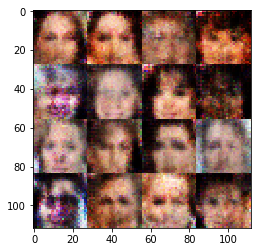

Epoch 1/1 ,  Batch 1510 ,  Generator Loss: 5.1313 ,  Discriminator Loss: 0.0648
Epoch 1/1 ,  Batch 1520 ,  Generator Loss: 5.1436 ,  Discriminator Loss: 0.0648
Epoch 1/1 ,  Batch 1530 ,  Generator Loss: 5.0966 ,  Discriminator Loss: 0.0650
Epoch 1/1 ,  Batch 1540 ,  Generator Loss: 5.0824 ,  Discriminator Loss: 0.0647
Epoch 1/1 ,  Batch 1550 ,  Generator Loss: 5.1030 ,  Discriminator Loss: 0.0647
Epoch 1/1 ,  Batch 1560 ,  Generator Loss: 5.0880 ,  Discriminator Loss: 0.0648
Epoch 1/1 ,  Batch 1570 ,  Generator Loss: 5.1936 ,  Discriminator Loss: 0.0646
Epoch 1/1 ,  Batch 1580 ,  Generator Loss: 5.1692 ,  Discriminator Loss: 0.0645


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches
          ,celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.